<a href="https://colab.research.google.com/github/neilalden/thesis/blob/master/the_sis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install dependencies

In [21]:
%%time 
!apt install gdal-bin python-gdal python3-gdal 
!apt install python3-rtree 
!pip install git+git://github.com/geopandas/geopandas.git
!pip install descartes 
!pip install folium
!pip install plotly_express
!pip install geoplot
!pip install scikit-learn-extra
!pip install scikit-learn-extra
!git clone https://github.com/jqmviegas/jqm_cvi.git
%cd jqm_cvi
import sys, os
sys.path.append(os.getcwd())

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-rtree is already the newest version (0.8.3+ds-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-txqdj3ur
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-txqdj3u

#Import libraries

In [22]:
import geopandas as gpd
import geoplot as gplt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from pylab import rcParams
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans,MeanShift, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from jqmcvi import base
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

In [23]:
drive.mount('/content/drive')
image_dir = '/content/drive/MyDrive/the sis/images/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Preprocess Data

In [24]:
# SHP files from https://github.com/justinelliotmeyers/official_philippines_shapefile_data_2016
gis_path = "/content/drive/MyDrive/Colab Notebooks/GIS/region_4a_barangay_gis/PH04.shp"
gis_df = gpd.read_file(gis_path)
gis_df= gis_df[gis_df["Mun_Name"] == "LOS BAÑOS"]
gis_df['Bgy_Name'] = gis_df['Bgy_Name'].str.lower()

# coordinates from https://www.philatlas.com/luzon/r04a/laguna/los-banos/anos.html
brngy_coordinates_path = "/content/drive/MyDrive/Colab Notebooks/datasets/brngy_coordinates - Sheet1.csv"
coor_df_pd = pd.read_csv(brngy_coordinates_path)
coor_df = gpd.GeoDataFrame(coor_df_pd, geometry=gpd.points_from_xy(coor_df_pd["longitude"],coor_df_pd["latitude"]))

# COVID-19 Cases Dataset from https://losbanos.gov.ph/covid_cases
new_cases_path = "/content/drive/MyDrive/Colab Notebooks/datasets/Daily Cases - New.csv"
new_cases_df = pd.read_csv(new_cases_path,parse_dates=True)

ongoing_cases_path = "/content/drive/MyDrive/Colab Notebooks/datasets/Daily Cases - Ongoing.csv"
ongoing_cases_df = pd.read_csv(ongoing_cases_path,parse_dates=True)

susceptible_cases_path = "/content/drive/MyDrive/Colab Notebooks/datasets/Daily Cases - Susceptible.csv"
susceptible_cases_df = pd.read_csv(susceptible_cases_path,parse_dates=True)

probable_cases_path = "/content/drive/MyDrive/Colab Notebooks/datasets/Daily Cases - Probable.csv"
probable_cases_df = pd.read_csv(probable_cases_path,parse_dates=True)

In [25]:
gis_df_copy = coor_df.copy()

# gis_df_copy.to_file('/content/drive/MyDrive/lb_gis.dbf')
gis_df_copy.to_file('/content/drive/MyDrive/lb_gis.zip', driver='ESRI Shapefile')
# gis_df_copy.to_csv('/content/drive/MyDrive/lb_gis.csv')

In [26]:
new_cases_df.drop(['total','BJMP'],axis='columns', inplace=True)
ongoing_cases_df.drop(['total','BJMP'],axis='columns', inplace=True)
susceptible_cases_df.drop(['total','BJMP'],axis='columns', inplace=True)
probable_cases_df.drop(['total','BJMP'],axis='columns', inplace=True)

In [27]:
weekly_new_cases = new_cases_df.groupby(new_cases_df.index // 14).sum()
weekly_ongoing_cases = ongoing_cases_df.groupby(ongoing_cases_df.index // 14).sum()
weekly_susceptible_cases = susceptible_cases_df.groupby(susceptible_cases_df.index // 14).sum()
weekly_probable_cases = probable_cases_df.groupby(probable_cases_df.index // 14).sum()

In [28]:
weekly_df = {}
brngys = list(weekly_ongoing_cases.columns)

for i in range(0,len(weekly_ongoing_cases)):
    weekly_df[i] = pd.DataFrame(columns=['brngy','ongoing', 'susceptible', 'probable'])
    
    ongoing = weekly_ongoing_cases.loc[i].tolist()
    susceptible = weekly_susceptible_cases.loc[i].tolist()
    probable = weekly_probable_cases.loc[i].tolist()
    
    weekly_df[i]["brngy"] = pd.Series(brngys)
    weekly_df[i]["ongoing"] = pd.Series(ongoing)
    weekly_df[i]["susceptible"] = pd.Series(susceptible)
    weekly_df[i]["probable"] = pd.Series(probable)

In [29]:
scaler = preprocessing.StandardScaler()
for i in range(0,len(weekly_df)):
  weekly_df[i]["ongoing"] = scaler.fit_transform(weekly_df[i][["ongoing"]])
  weekly_df[i]["susceptible"] = scaler.fit_transform(weekly_df[i][["susceptible"]])
  weekly_df[i]["probable"] = scaler.fit_transform(weekly_df[i][["probable"]])

In [30]:
pca = PCA(n_components=1)
for i in range(0, len(weekly_df)):
  X = weekly_df[i][["susceptible", "probable"]]
  weekly_df[i]["sus_prob_PCA"] = pca.fit_transform(X)
  weekly_df[i].drop(['susceptible','probable'],axis='columns', inplace=True)

In [31]:
color = {
    0:"#228b22",
    1:"#9acd32",
    2:"#ccff33",
    3:"#ffd700",
    4:"orange",
    5:"#ff4500",
    6:"#4d0000"
}

#K-Means

In [58]:
for i in range(0,len(weekly_df)-1):
  sse = []
  k_rng = range(1,10)
  curr_df = weekly_df[i][["ongoing","sus_prob_PCA"]]
  for k in k_rng:
      km = KMeans(n_clusters=k, random_state=0)
      km.fit(curr_df)
      sse.append(km.inertia_)
  # plt.rcParams["figure.figsize"] = (6,4)
  # plt.title(f'Elbow method for bi-weekly {i+1}')
  # plt.xlabel('K')
  # plt.ylabel('Within sum of squared error')
  # plt.grid(which="major",color="#ccc", linestyle="--")
  # plt.plot(k_rng,sse)
  # # plt.savefig(f'{image_dir}K-Means/elbow{i+1}.png')
  # plt.show()

In [57]:
for i in range(0,len(weekly_df)-1):
  curr_df = weekly_df[i][["ongoing","sus_prob_PCA"]]
  k_means_per_k = [KMeans(n_clusters=k, random_state=0).fit(curr_df) for k in range(1,10)]
  silhouette_scores = [silhouette_score(curr_df, model.labels_) for model in k_means_per_k[1:]]
  # _ = plt.plot(range(2,10), silhouette_scores, "bo-", color="blue",linewidth=3,markersize=8,label="Silhouette curve")
  # _ = plt.xlabel("$k$")
  # _ = plt.ylabel("Silhoutte score")
  # _ = plt.grid(which="major",color="#ccc", linestyle="--")
  # _ = plt.title(f"Silhoutte score for optimal cluster in bi-weekly {i+1}")

  # k = np.argmax(silhouette_scores) + 2
  # _ = plt.axvline(x=k, linestyle="--", c="green", linewidth=3,label="Optimal number of clusters ({})".format(k))
  # _ = plt.scatter(k, silhouette_scores[k-2],c="red",s=400)
  # _ = plt.legend(shadow=True)
  # # plt.savefig(f'{image_dir}K-Means/silhoutte{i+1}.png')
  # _ = plt.show()

In [34]:
for i in range(0,len(weekly_df)):
  curr_df = weekly_df[i][["ongoing","sus_prob_PCA"]]
  k_means_per_k = [KMeans(n_clusters=k, random_state=0).fit(curr_df) for k in range(1,10)]
  silhouette_scores = [silhouette_score(curr_df, model.labels_) for model in k_means_per_k[1:]]
  k = np.argmax(silhouette_scores) + 2
  
  km = KMeans(n_clusters=k, random_state=0)
  y_predicted = km.fit_predict(weekly_df[i][["ongoing","sus_prob_PCA"]])


  idx = np.argsort(km.cluster_centers_.sum(axis=1))
  lut = np.zeros_like(idx)
  lut[idx] = np.arange(k)
  arr = []
  for j in y_predicted:
    arr.append(lut[j])
  weekly_df[i]['kmeans_cluster']=arr
  gis_df[f"kmeans_cluster {i+1}"] = arr

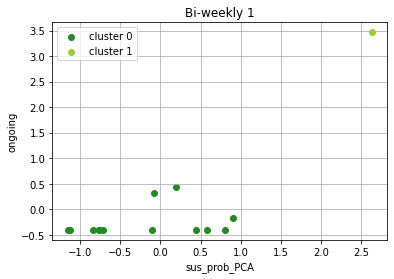

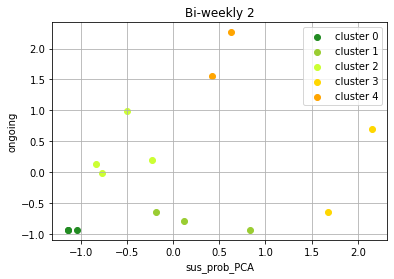

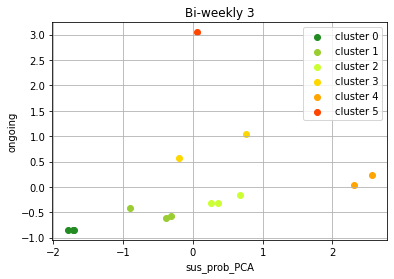

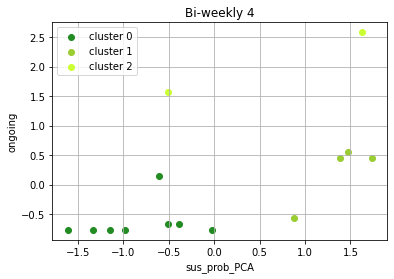

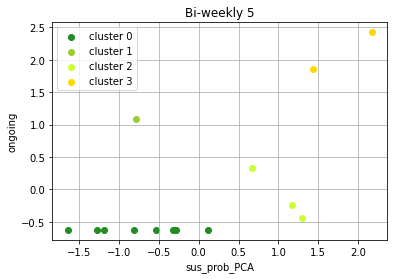

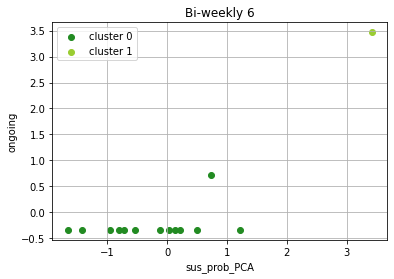

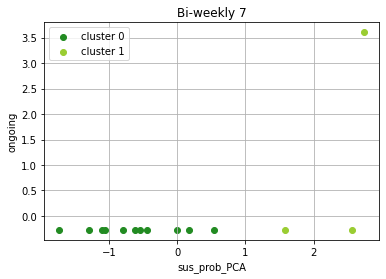

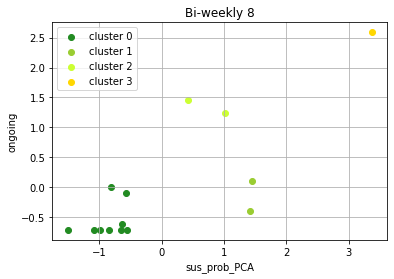

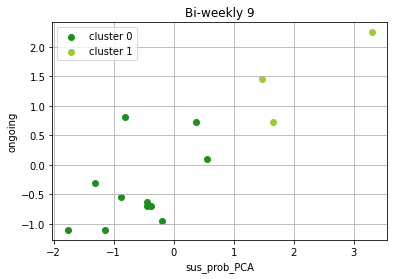

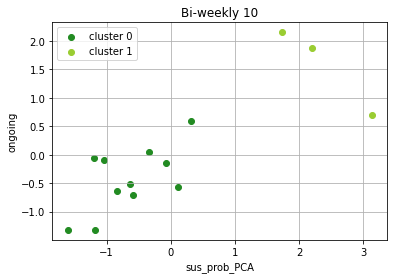

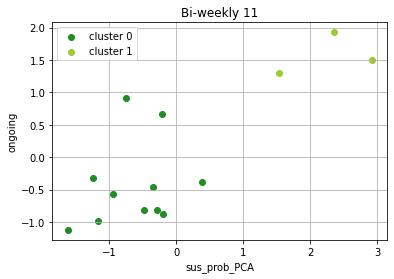

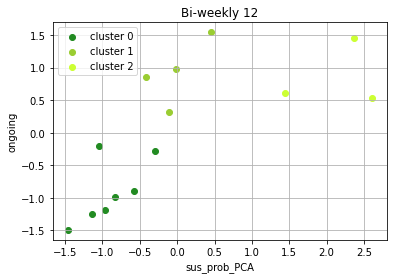

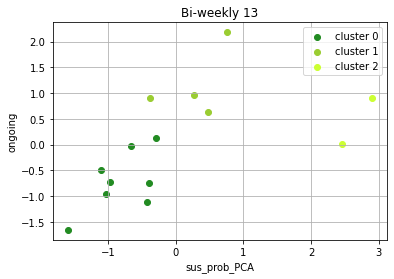

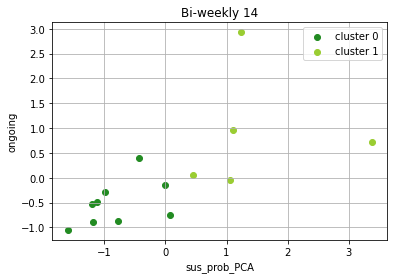

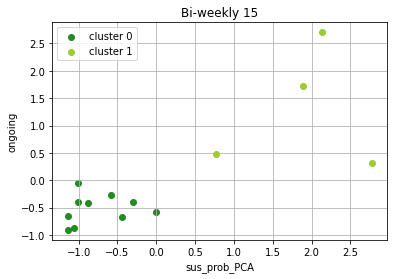

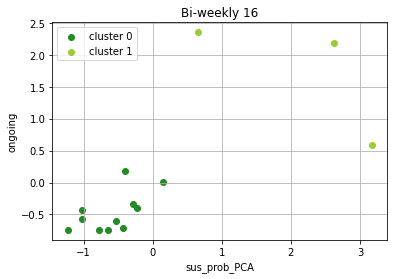

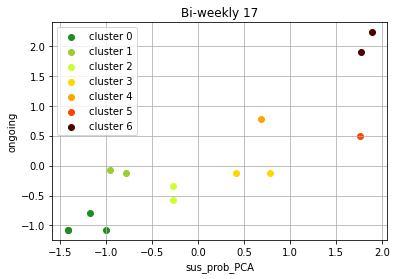

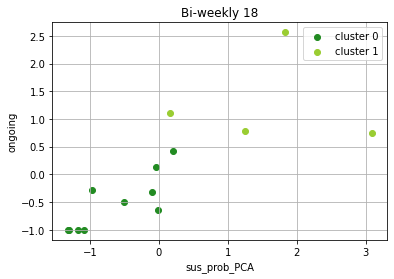

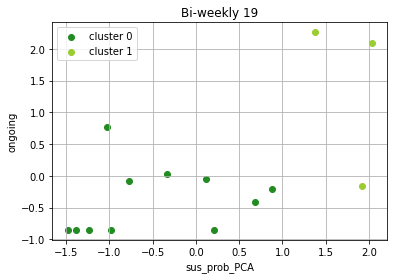

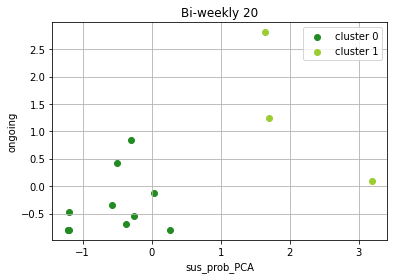

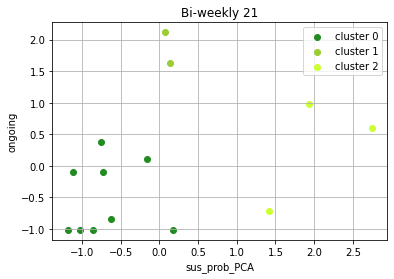

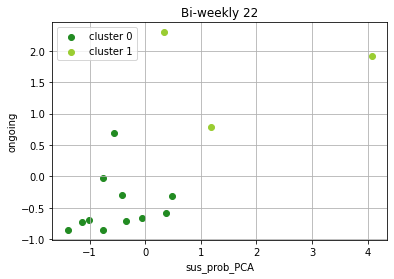

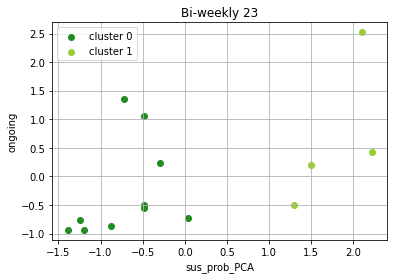

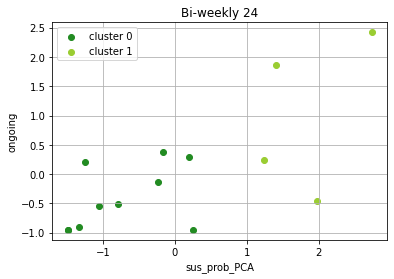

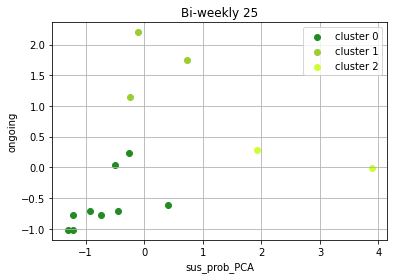

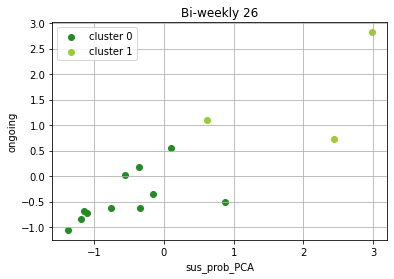

In [35]:
for i in range(0, len(weekly_df)-1):
  label1="sus_prob_PCA"
  label2="ongoing"
  curr_df = weekly_df[i]
  
  for j in range(0, len(curr_df['kmeans_cluster'].unique())):
     plt.scatter(curr_df[curr_df["kmeans_cluster"]==j][label1],curr_df[curr_df["kmeans_cluster"]==j][label2], label=f"cluster {j}", color=color[j])

  plt.xlabel(label1)
  plt.ylabel(label2)
  plt.title(f"Bi-weekly {i+1}")
  plt.grid(True)
  plt.legend()
  # plt.savefig(f'{image_dir}K-Means/scatter{i+1}.png')
  plt.show()

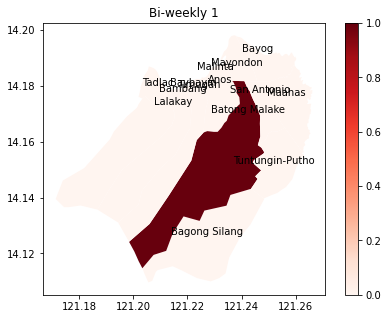

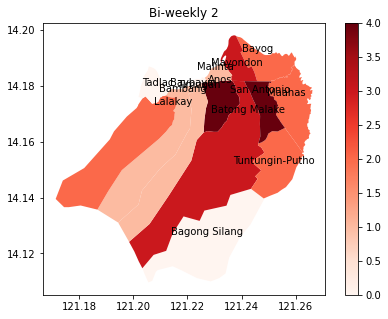

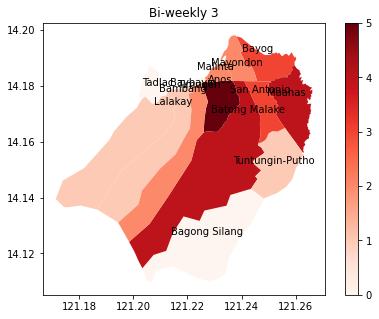

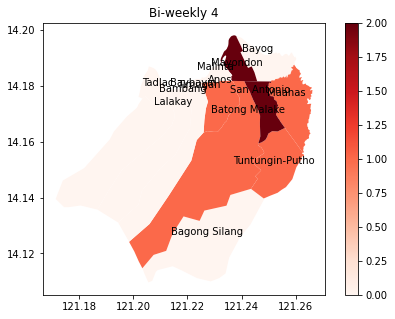

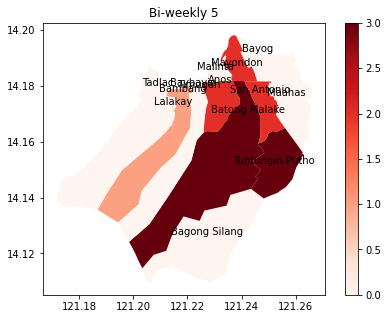

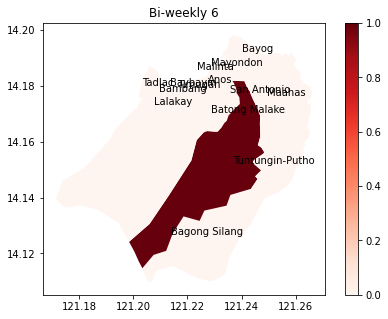

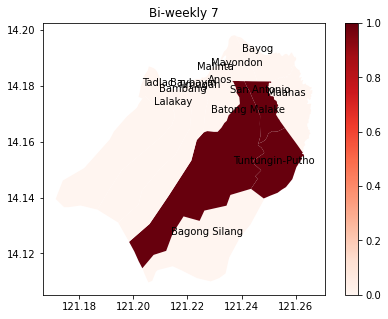

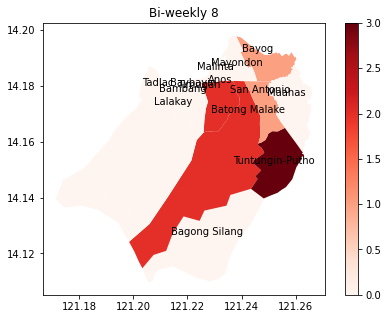

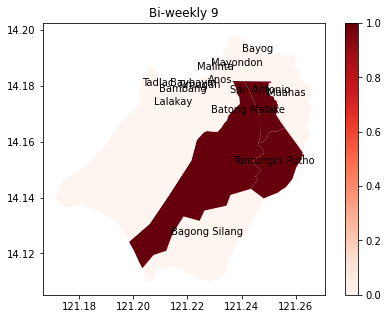

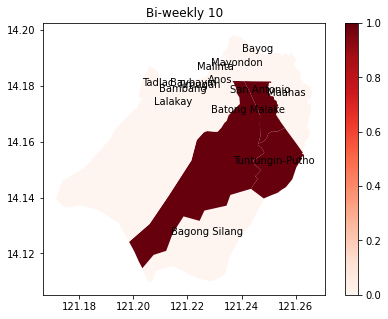

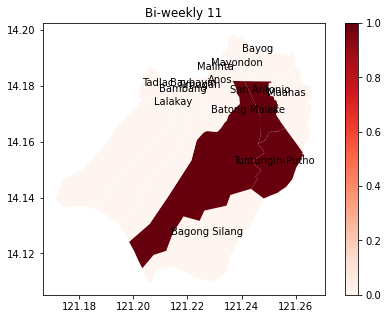

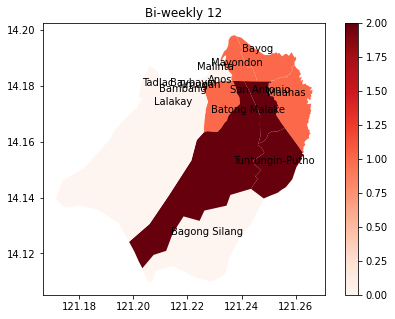

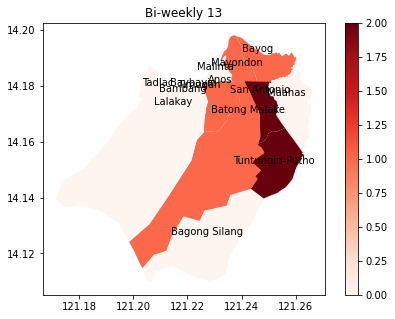

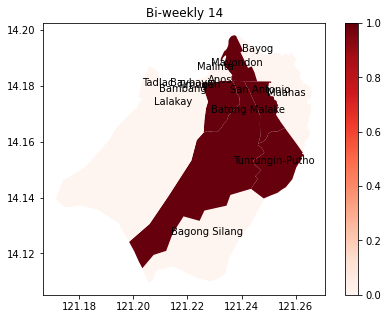

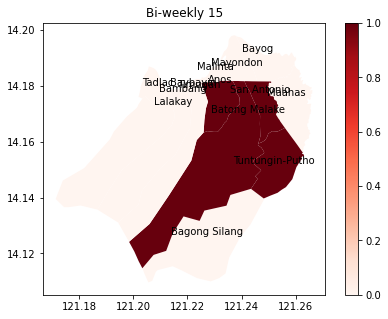

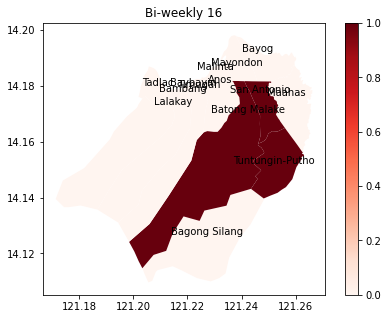

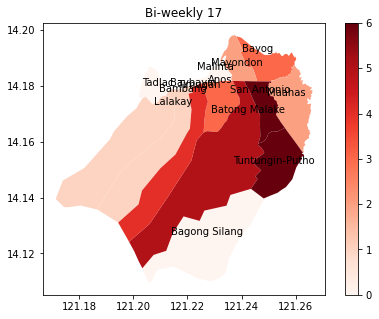

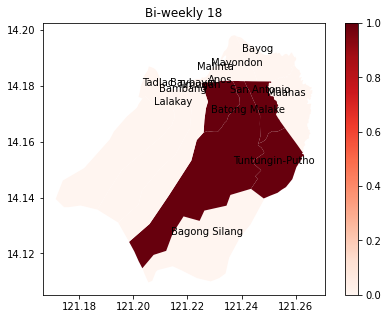

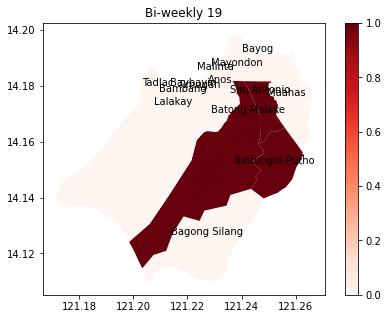

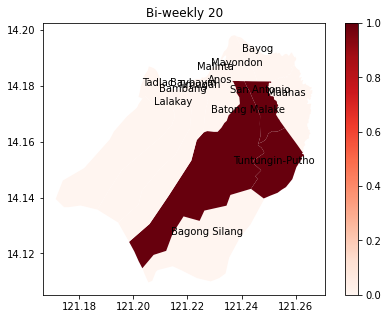

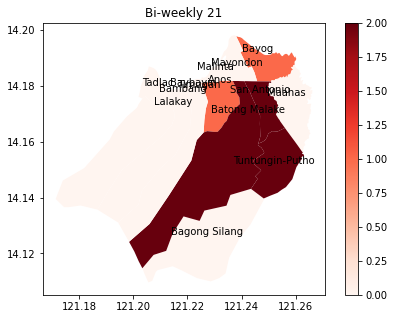

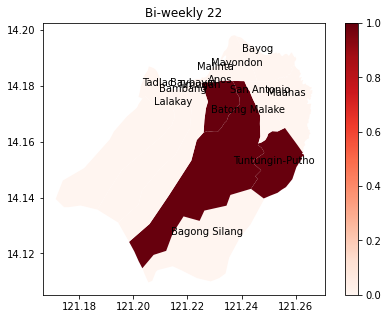

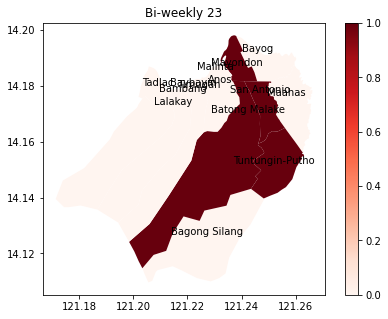

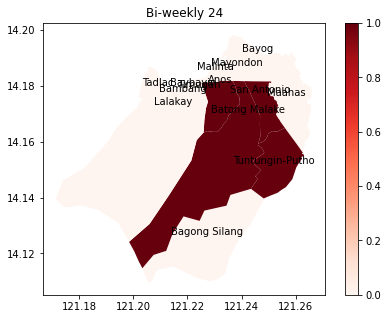

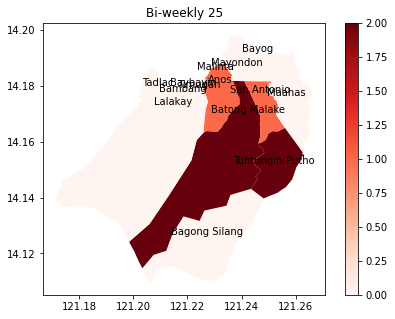

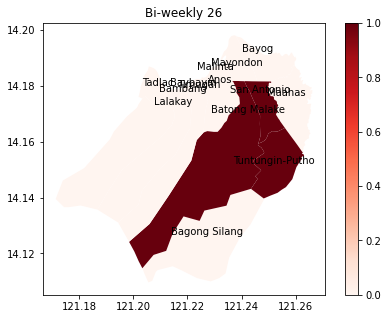

In [36]:
rcParams["figure.figsize"] = 7, 5
for i in range(0,len(weekly_df)-1):
    axis = gis_df.plot(column=f'kmeans_cluster {i+1}', cmap="Reds",  legend=True)
    plt.title(f"Bi-weekly {i+1}")
    # coor_df.plot(ax=axis, color="black")
    for x, y, label in zip(coor_df["longitude"], coor_df["latitude"], coor_df["brngy"]):
      axis.annotate(label, xy=(x, y),horizontalalignment="center")
    # plt.savefig(f'{image_dir}K-Means/map{i+1}.png')
    plt.show()

#K-Medoids

In [55]:
for i in range(0,len(weekly_df)-1):
  sse = []
  k_rng = range(1,10)
  curr_df = weekly_df[i][["ongoing","sus_prob_PCA"]]
  for k in k_rng:
      km = KMedoids(n_clusters=k, random_state=0)
      km.fit(curr_df)
      sse.append(km.inertia_)
  # plt.rcParams["figure.figsize"] = (6,4)
  # plt.title(f'Elbow method for bi-weekly {i+1}')
  # plt.xlabel('K')
  # plt.ylabel('Within sum of squared error')
  # plt.grid(which="major",color="#ccc", linestyle="--")
  # plt.plot(k_rng,sse)
  # plt.savefig(f'{image_dir}K-Medoids/elbow{i+1}.png')
  # plt.show()

In [56]:
for i in range(0,len(weekly_df)-1):
  curr_df = weekly_df[i][["ongoing","sus_prob_PCA"]]
  k_medoids_per_k = [KMedoids(n_clusters=k, random_state=0).fit(curr_df) for k in range(1,10)]
  silhouette_scores = [silhouette_score(curr_df, model.labels_) for model in k_medoids_per_k[1:]]
  # _ = plt.plot(range(2,10), silhouette_scores, "bo-", color="blue",linewidth=3,markersize=8,label="Silhouette curve")
  # _ = plt.xlabel("$k$")
  # _ = plt.ylabel("Silhoutte score")
  # _ = plt.grid(which="major",color="#ccc", linestyle="--")
  # _ = plt.title(f"Silhoutte score for optimal cluster in bi-weekly {i+1}")

  # k = np.argmax(silhouette_scores) + 2
  # _ = plt.axvline(x=k, linestyle="--", c="green", linewidth=3,label="Optimal number of clusters ({})".format(k))
  # _ = plt.scatter(k, silhouette_scores[k-2],c="red",s=400)
  # _ = plt.legend(shadow=True)
  # # plt.savefig(f'{image_dir}K-Medoids/silhoutte{i+1}.png')
  # _ = plt.show()

In [39]:
for i in range(0,len(weekly_df)):
  curr_df = weekly_df[i][["ongoing","sus_prob_PCA"]]
  k_medoids_per_k = [KMedoids(n_clusters=k, random_state=0).fit(curr_df) for k in range(1,10)]
  silhouette_scores = [silhouette_score(curr_df, model.labels_) for model in k_medoids_per_k[1:]]
  k = np.argmax(silhouette_scores) + 2

  km = KMedoids(n_clusters=k, random_state=0)
  y_predicted = km.fit_predict(weekly_df[i][["ongoing","sus_prob_PCA"]])

  idx = np.argsort(km.cluster_centers_.sum(axis=1))
  lut = np.zeros_like(idx)
  lut[idx] = np.arange(k)
  arr = []
  for j in y_predicted:
    arr.append(lut[j])
  weekly_df[i]['kmedoids_cluster']=arr
  gis_df[f"kmedoids_cluster {i+1}"] = arr

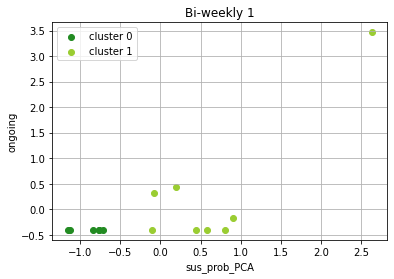

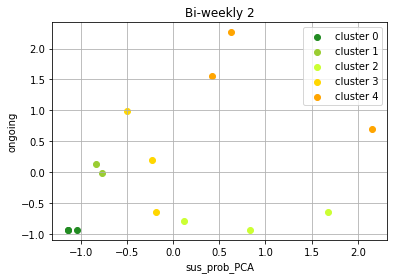

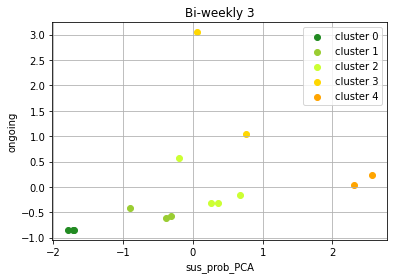

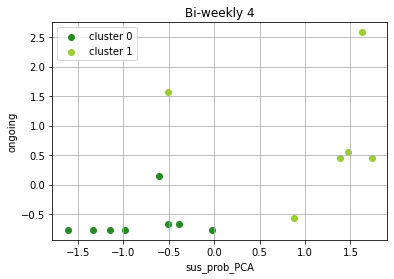

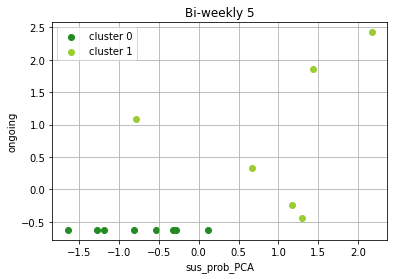

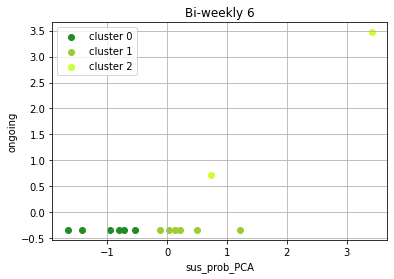

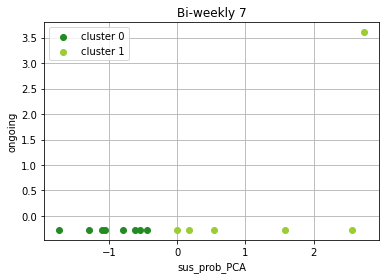

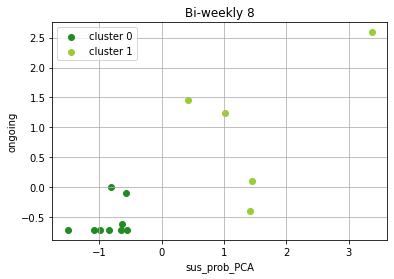

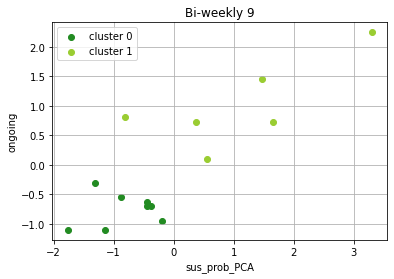

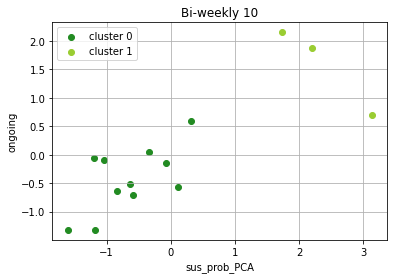

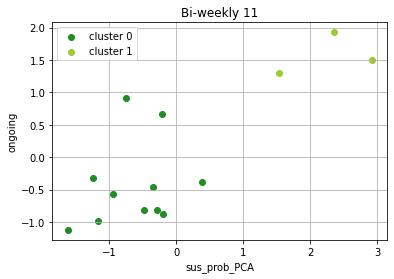

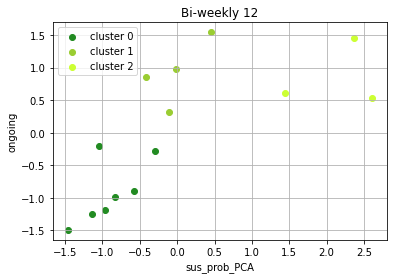

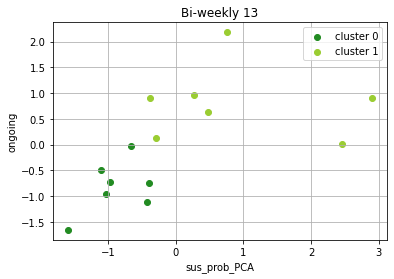

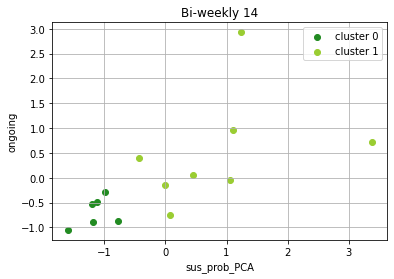

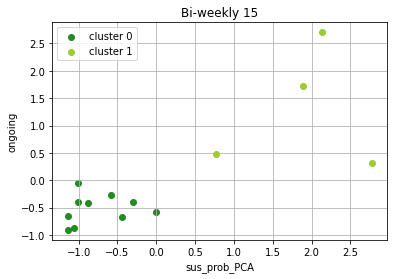

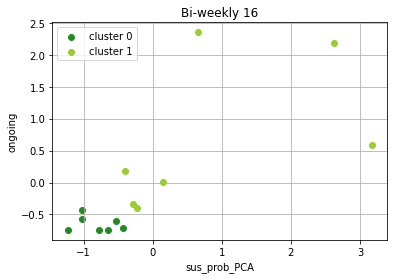

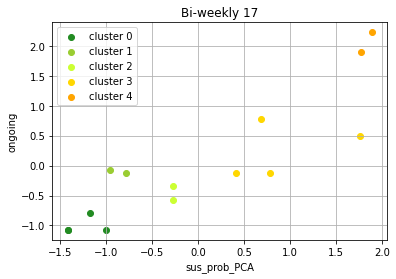

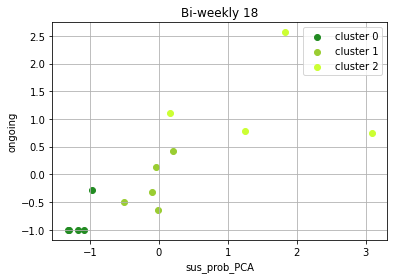

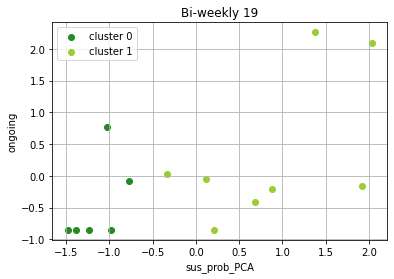

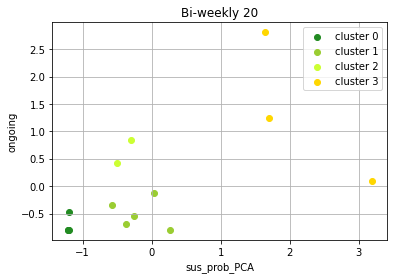

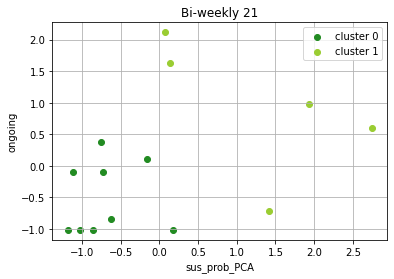

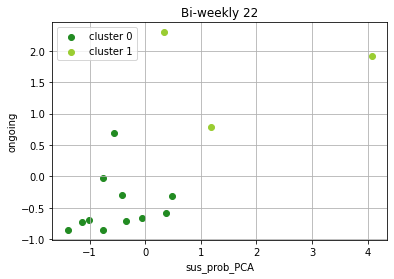

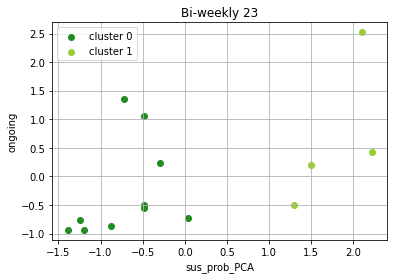

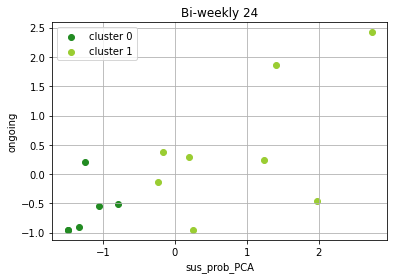

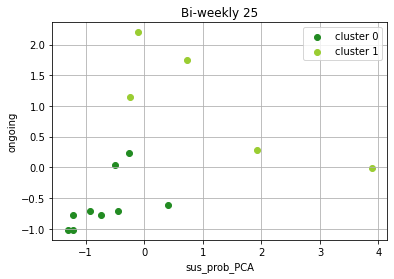

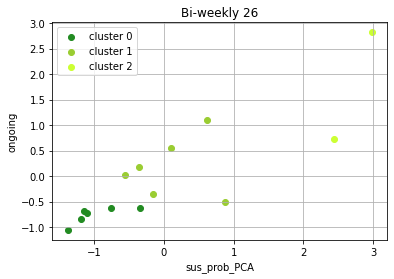

In [40]:
for i in range(0, len(weekly_df)-1):
  label1="sus_prob_PCA"
  label2="ongoing"
  curr_df = weekly_df[i]
  
  for j in range(0, len(curr_df['kmedoids_cluster'].unique())):
     plt.scatter(curr_df[curr_df["kmedoids_cluster"]==j][label1],curr_df[curr_df["kmedoids_cluster"]==j][label2], label=f"cluster {j}", color=color[j])

  plt.xlabel(label1)
  plt.ylabel(label2)
  plt.title(f"Bi-weekly {i+1}")
  plt.grid(True)
  plt.legend()
  # plt.savefig(f'{image_dir}K-Medoids/scatter{i+1}.png')
  plt.show()

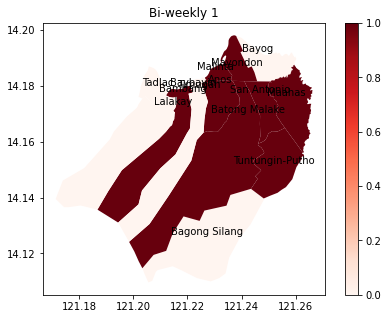

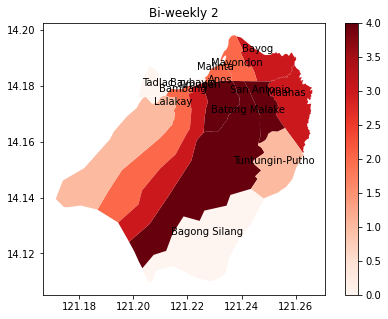

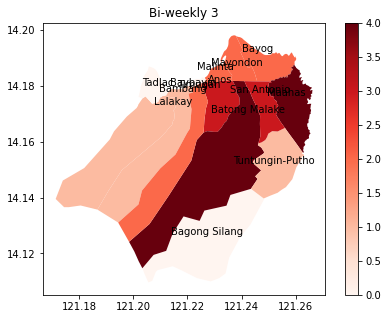

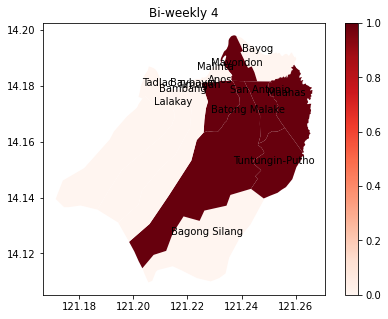

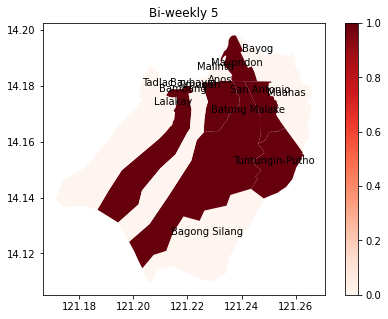

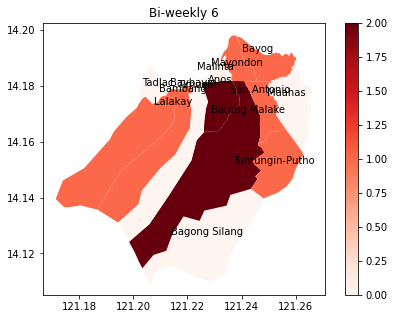

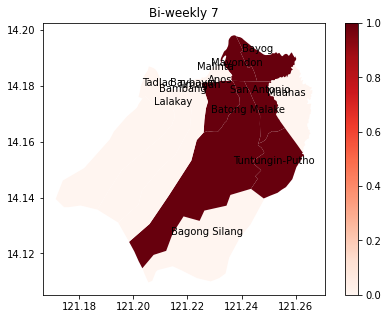

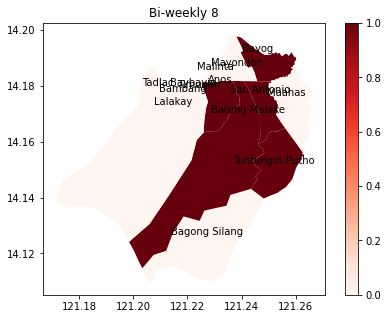

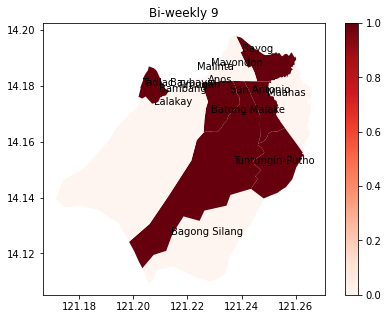

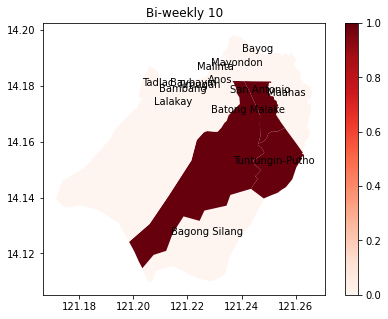

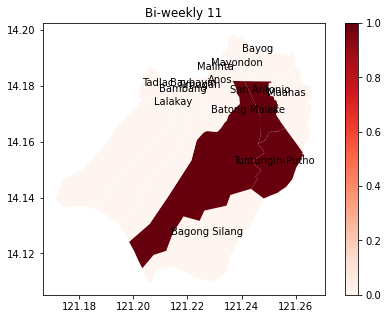

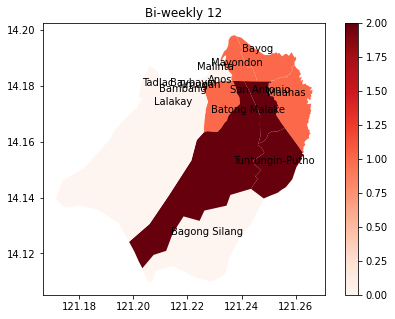

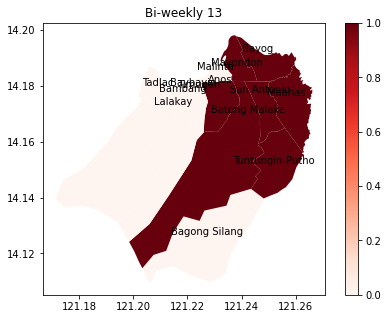

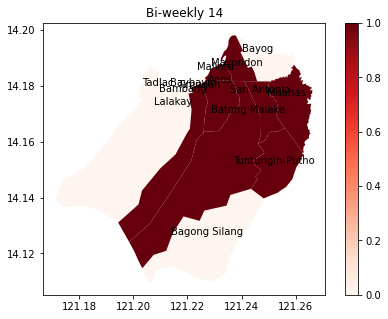

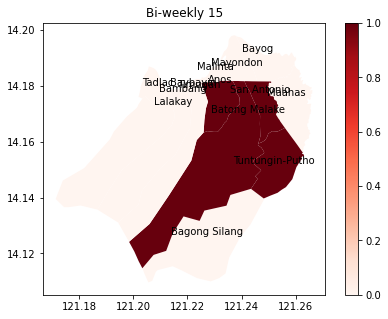

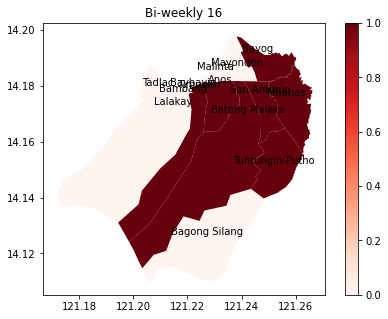

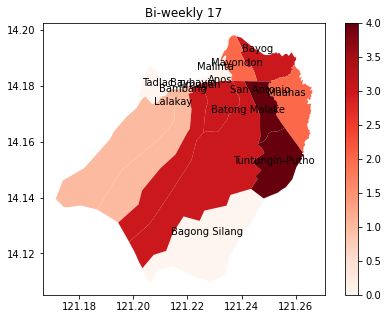

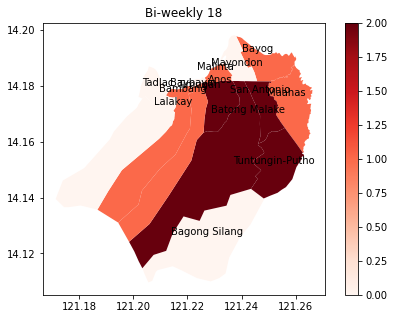

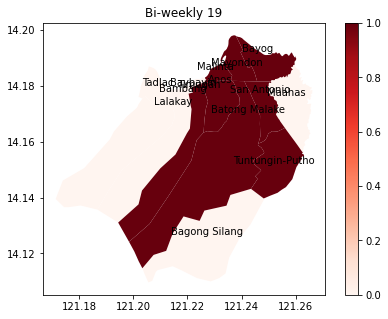

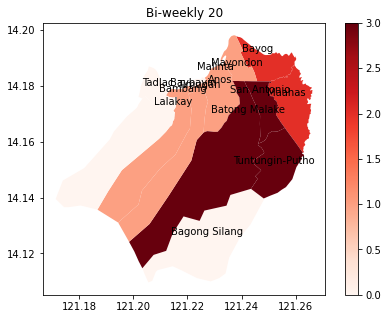

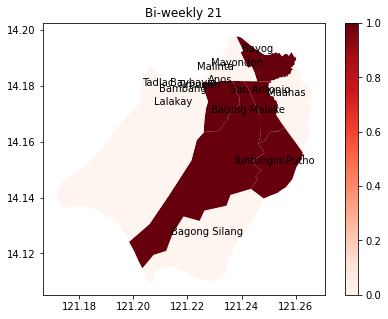

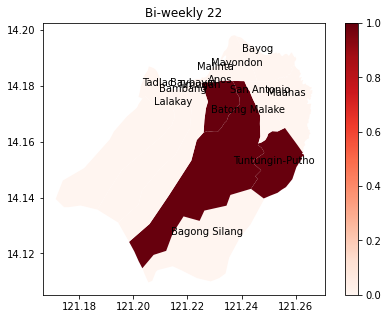

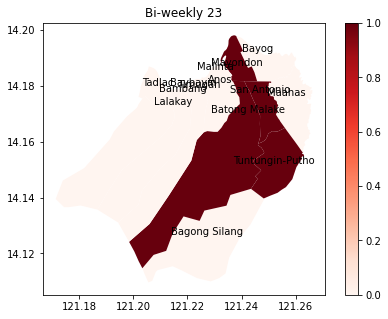

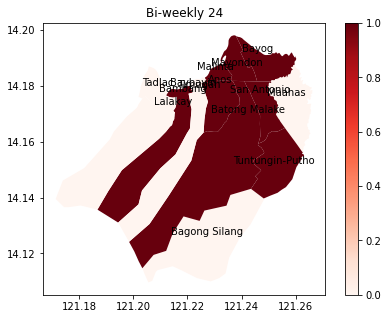

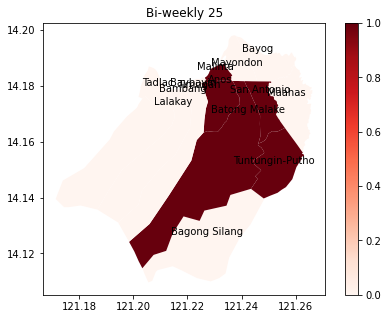

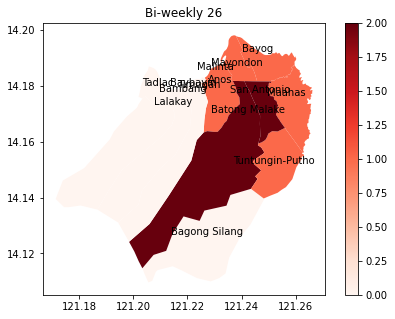

In [41]:
rcParams["figure.figsize"] = 7, 5
for i in range(0,len(weekly_df)-1):
    axis = gis_df.plot(column=f'kmedoids_cluster {i+1}', cmap="Reds",  legend=True)
    plt.title(f"Bi-weekly {i+1}")
    for x, y, label in zip(coor_df["longitude"], coor_df["latitude"], coor_df["brngy"]):
      axis.annotate(label, xy=(x, y),horizontalalignment="center")
    # plt.savefig(f'{image_dir}K-Medoids/map{i+1}.png')
    plt.show()

#Mean Shift

In [42]:
for i in range(0,len(weekly_df)):
  curr_df = weekly_df[i][["ongoing","sus_prob_PCA"]]
  meanshift_per_k = [MeanShift(bin_seeding=True).fit(curr_df) for k in range(1,10)]
  # silhouette_scores = [silhouette_score(curr_df, model.labels_) for model in meanshift_per_k[1:]]
  # k = np.argmax(silhouette_scores) + 2

  ms = MeanShift(bin_seeding=True)
  y_predicted = ms.fit_predict(weekly_df[i][["ongoing","sus_prob_PCA"]])

  idx = np.argsort(ms.cluster_centers_.sum(axis=1))
  lut = np.zeros_like(idx)
  lut[idx] = np.arange(len(np.unique(ms.labels_)))
  arr = []
  for j in y_predicted:
    arr.append(lut[j])
  weekly_df[i]['meanshift_cluster']=arr
  gis_df[f"meanshift_cluster {i+1}"] = arr

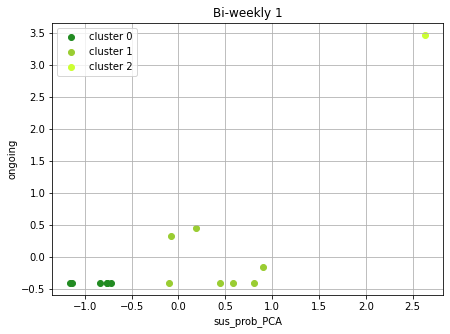

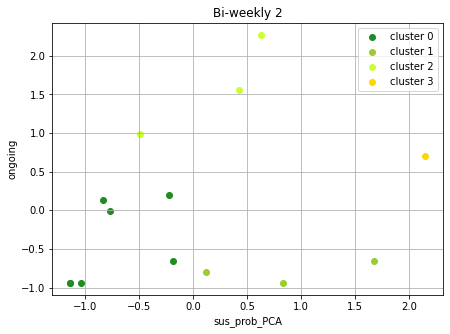

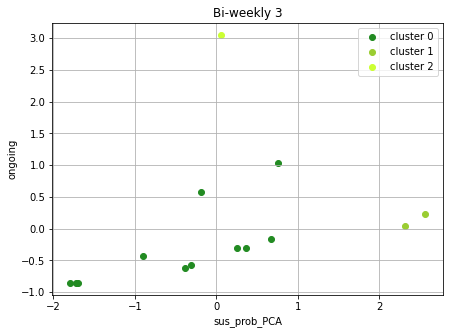

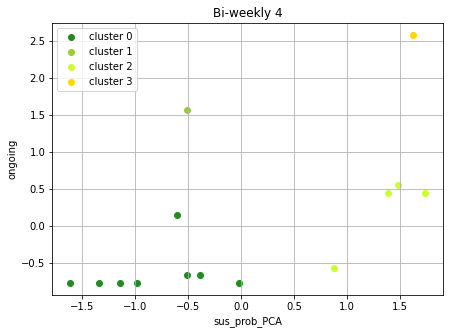

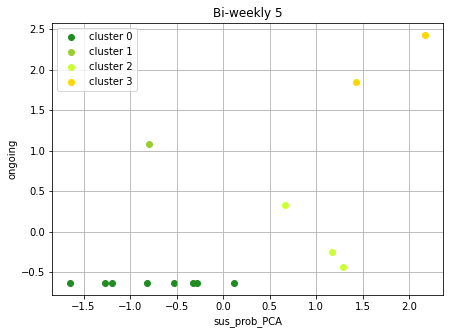

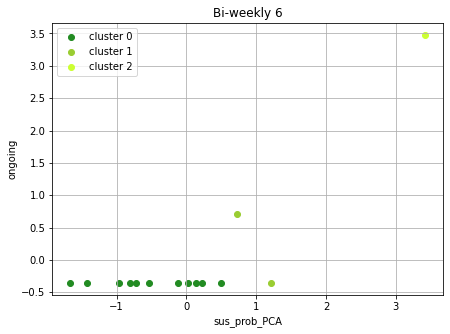

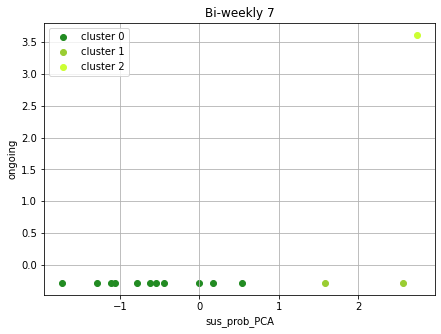

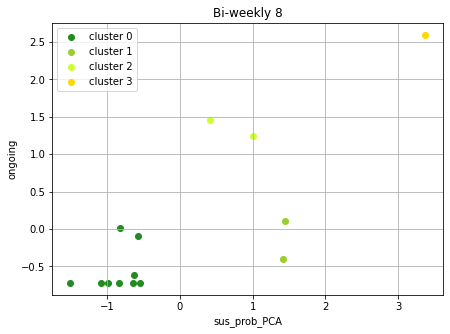

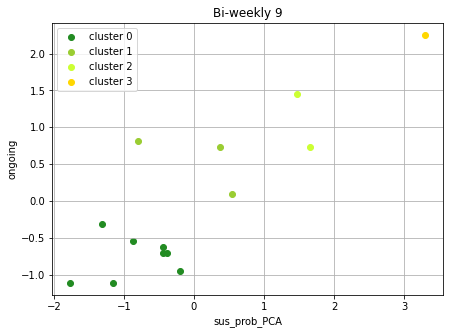

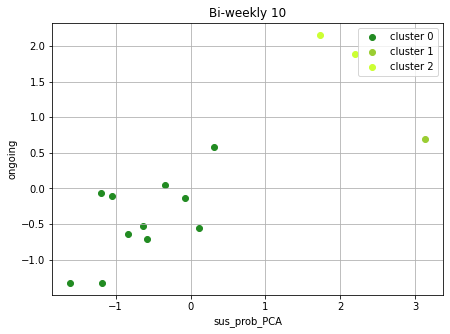

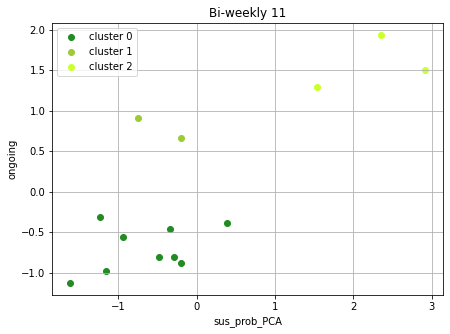

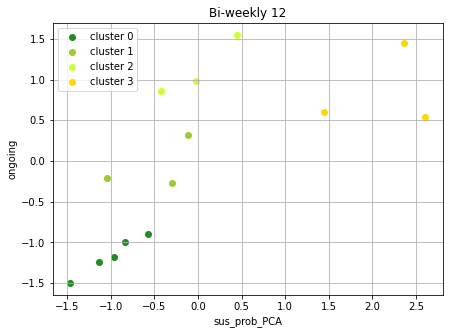

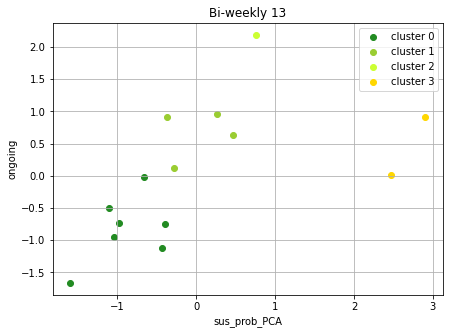

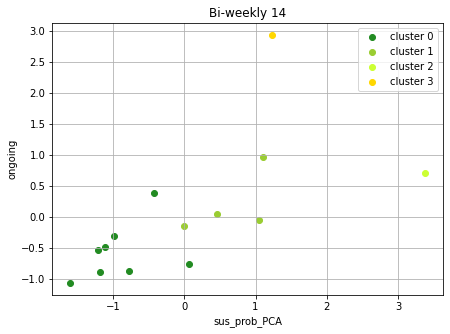

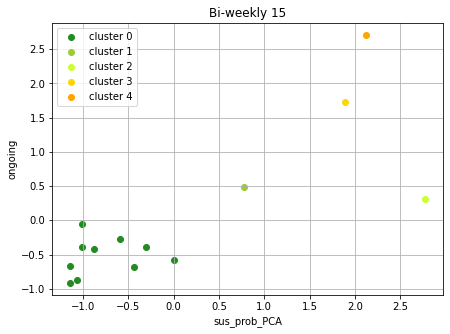

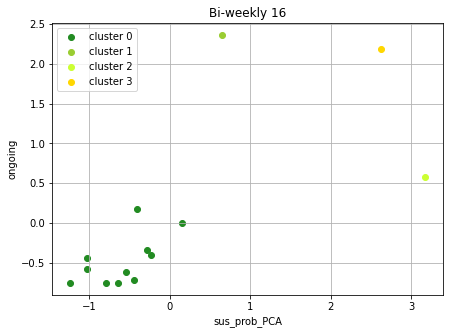

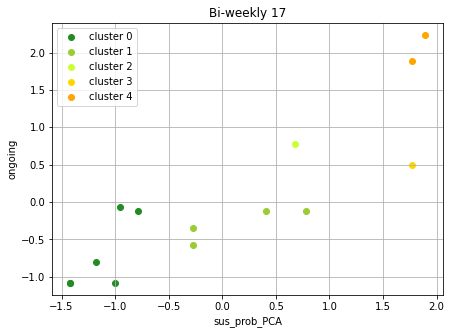

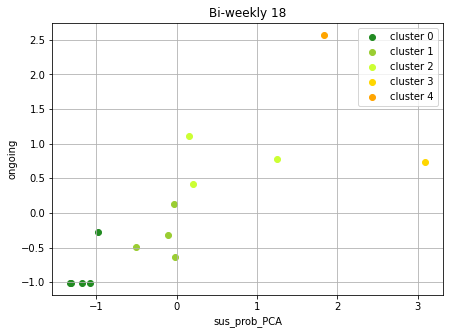

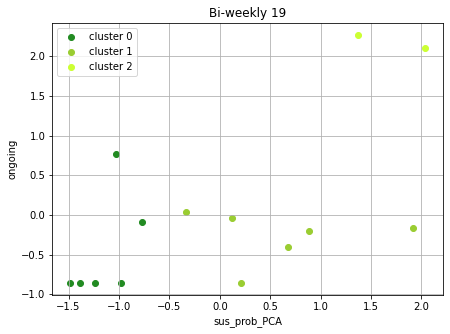

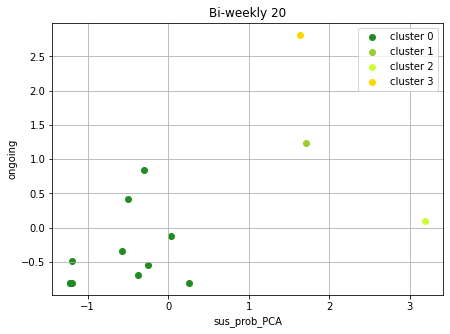

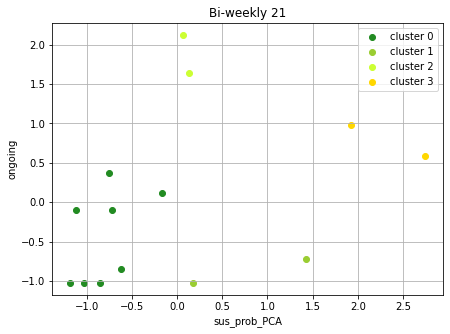

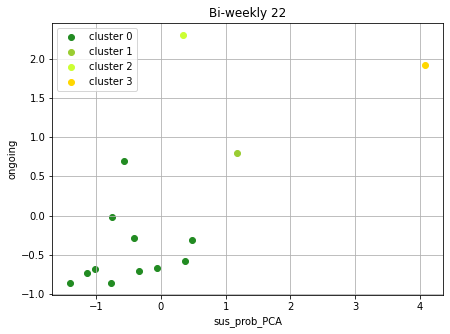

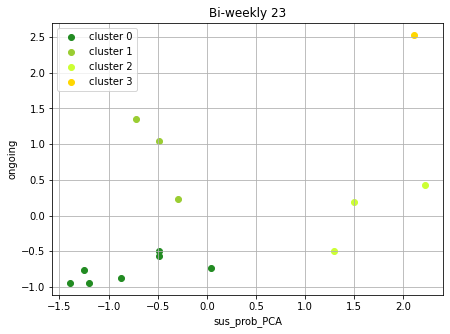

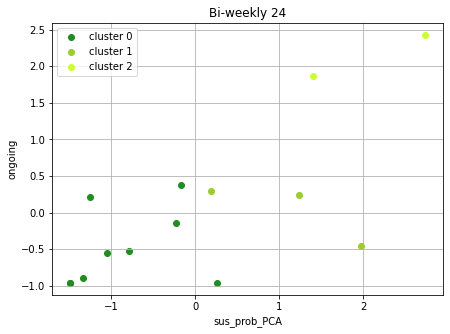

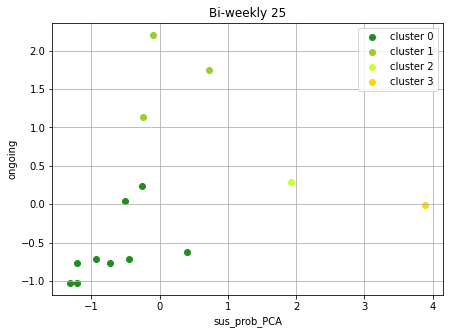

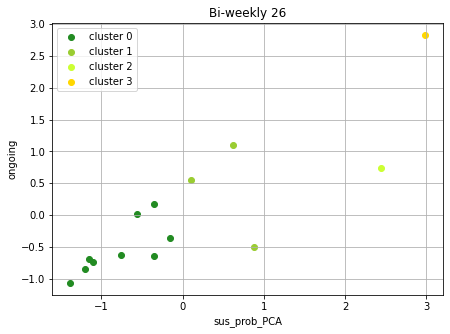

In [43]:
for i in range(0, len(weekly_df)-1):
  label1="sus_prob_PCA"
  label2="ongoing"
  curr_df = weekly_df[i]
  
  for j in range(0, len(curr_df['meanshift_cluster'].unique())):
     plt.scatter(curr_df[curr_df["meanshift_cluster"]==j][label1],curr_df[curr_df["meanshift_cluster"]==j][label2], label=f"cluster {j}", color=color[j])

  plt.xlabel(label1)
  plt.ylabel(label2)
  plt.title(f"Bi-weekly {i+1}")
  plt.grid(True)
  plt.legend()
  # plt.savefig(f'{image_dir}Mean Shift/scatter{i+1}.png')
  plt.show()

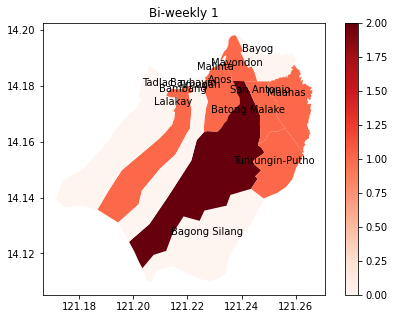

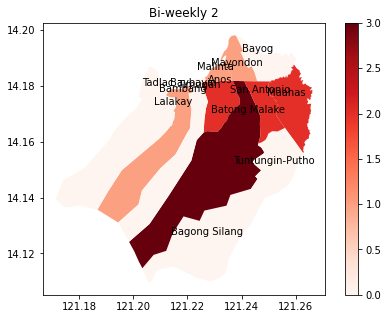

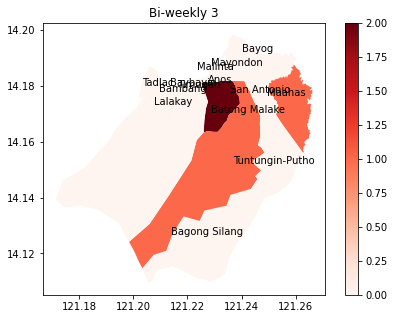

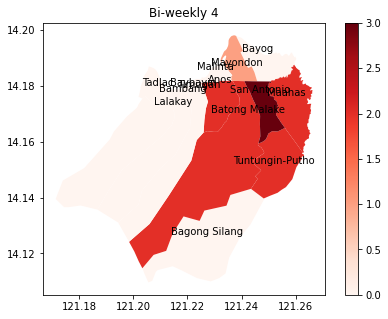

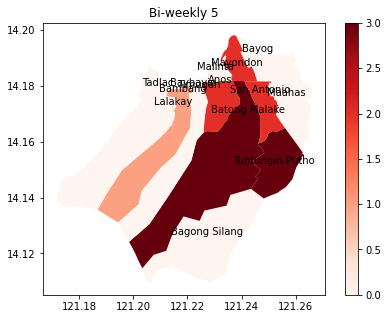

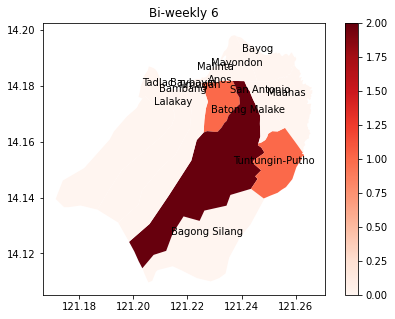

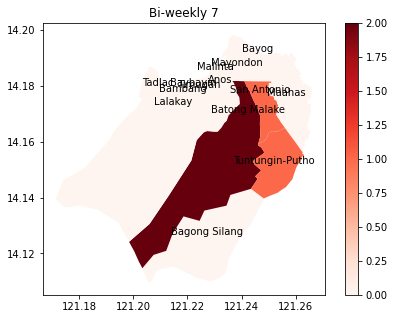

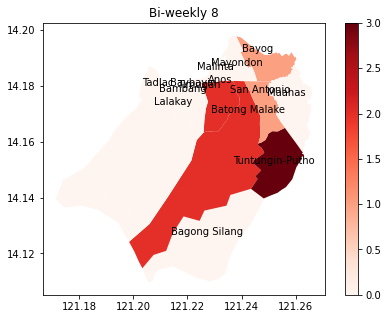

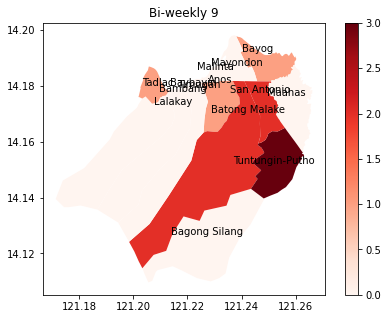

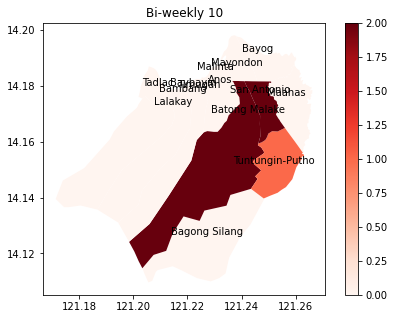

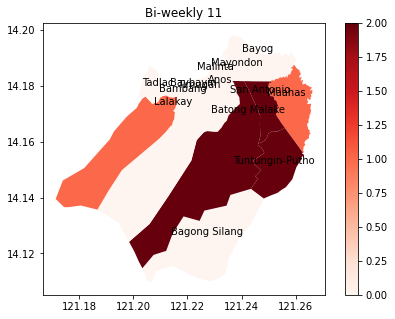

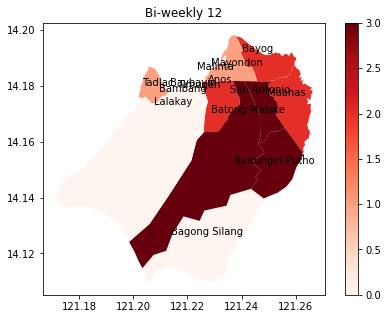

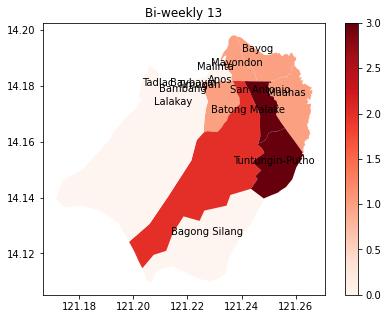

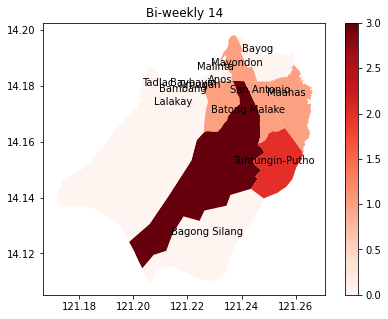

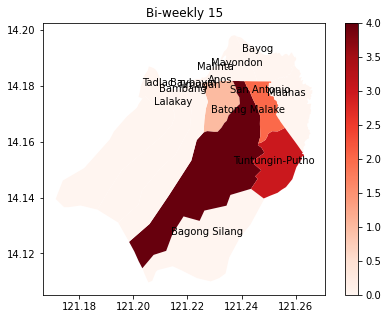

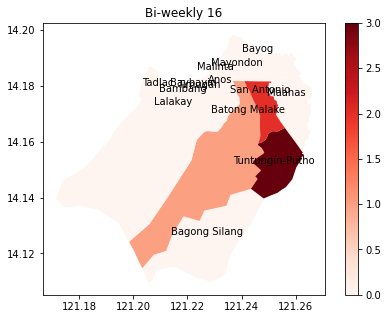

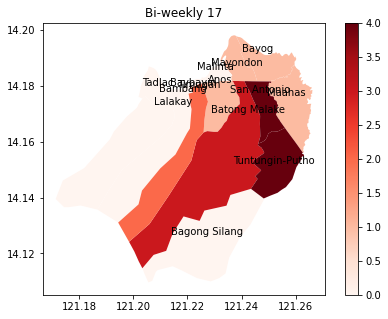

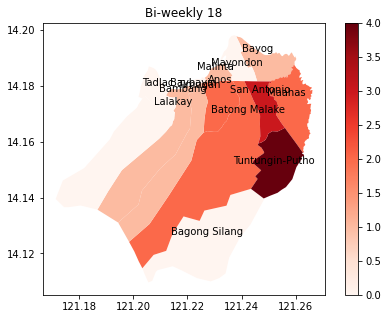

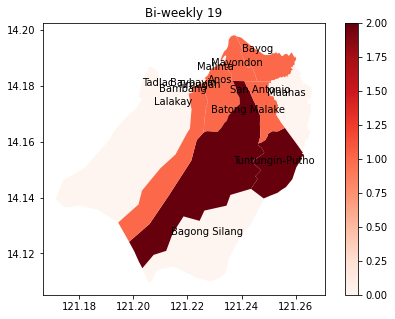

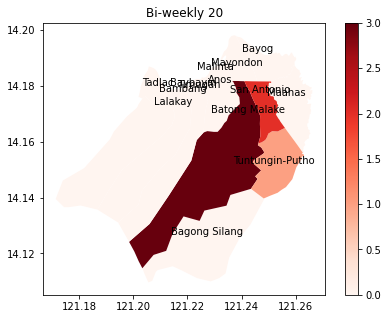

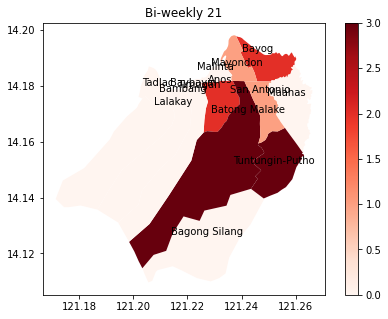

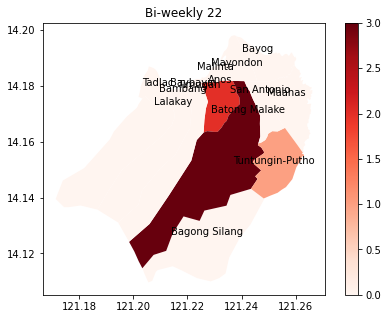

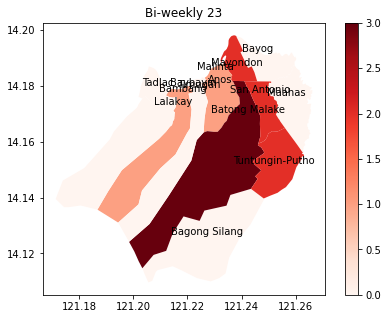

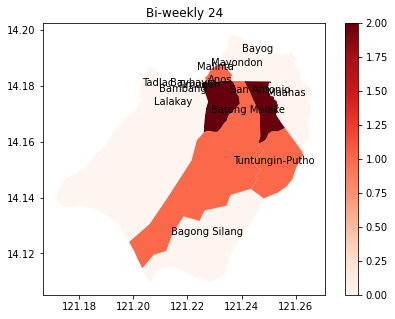

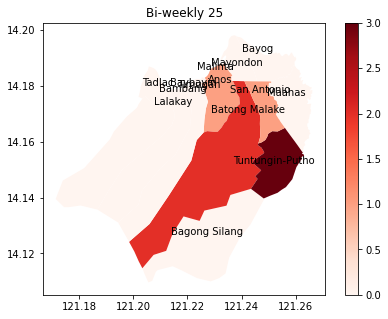

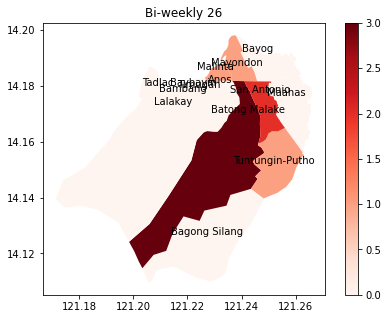

In [44]:
rcParams["figure.figsize"] = 7, 5
for i in range(0,len(weekly_df)-1):
    axis = gis_df.plot(column=f'meanshift_cluster {i+1}', cmap="Reds",  legend=True)
    plt.title(f"Bi-weekly {i+1}")
    for x, y, label in zip(coor_df["longitude"], coor_df["latitude"], coor_df["brngy"]):
      axis.annotate(label, xy=(x, y),horizontalalignment="center")
    # plt.savefig(f'{image_dir}Mean Shift/map{i+1}.png')
    plt.show()

#Dunn Index

In [45]:
kmeans_dunn = []
for i in range(len(weekly_df)-1):
  curr_df = weekly_df[i][["ongoing",	"sus_prob_PCA",	"kmeans_cluster"]]
  cluster_list = []
  for j in curr_df["kmeans_cluster"].unique():
    # print(curr_df.loc[curr_df["kmeans_cluster"] == j].values)
    cluster_list.append(curr_df.loc[curr_df["kmeans_cluster"] == j].values)
  # print("cluster_list",cluster_list)
  kmeans_dunn.append(base.dunn(cluster_list))

In [46]:
kmedoids_dunn = []
for i in range(len(weekly_df)-1):
  curr_df = weekly_df[i][["ongoing",	"sus_prob_PCA",	"kmedoids_cluster"]]
  cluster_list = []
  for j in curr_df["kmedoids_cluster"].unique():
    cluster_list.append(curr_df.loc[curr_df["kmedoids_cluster"] == j].values)
  kmedoids_dunn.append(base.dunn(cluster_list))

In [47]:
meanshift_dunn = []
for i in range(len(weekly_df)-1):
  curr_df = weekly_df[i][["ongoing",	"sus_prob_PCA",	"meanshift_cluster"]]
  cluster_list = []
  for j in curr_df["meanshift_cluster"].unique():
    cluster_list.append(curr_df.loc[curr_df["meanshift_cluster"] == j].values)
  meanshift_dunn.append(base.dunn(cluster_list))

In [48]:
dunn_df = pd.DataFrame(columns=["KMeans","KMedoids","MeanShift"])
dunn_df["KMeans"] = pd.Series(kmeans_dunn)
dunn_df["KMedoids"] = pd.Series(kmedoids_dunn)
dunn_df["MeanShift"] = pd.Series(meanshift_dunn)

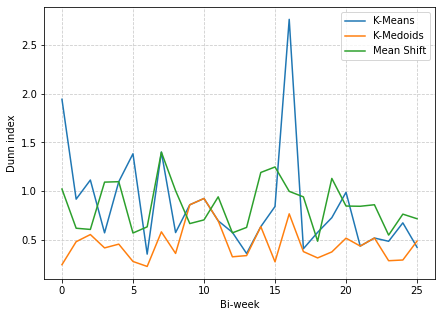

In [49]:
plt.plot(dunn_df["KMeans"], label="K-Means")
plt.plot(dunn_df["KMedoids"], label="K-Medoids")
plt.plot(dunn_df["MeanShift"], label="Mean Shift")
plt.grid(which="major",color="#ccc", linestyle="--")
plt.xlabel("Bi-week")
plt.ylabel("Dunn index")
plt.legend()

#Dendrogram

In [50]:
yearly_ongoing_cases = ongoing_cases_df.groupby(ongoing_cases_df.index // 366).sum()
yearly_susceptible_cases = susceptible_cases_df.groupby(susceptible_cases_df.index // 366).sum()
yearly_probable_cases = probable_cases_df.groupby(probable_cases_df.index // 366).sum()

yearly_df = pd.DataFrame(columns=["brngys","ongoing","suspect","probable"])
yearly_df["brngys"] = brngys
yearly_df["ongoing"]=pd.Series(yearly_ongoing_cases.loc[0].tolist())
yearly_df["suspect"]=pd.Series(yearly_susceptible_cases.loc[0].tolist())
yearly_df["probable"]=pd.Series(yearly_probable_cases.loc[0].tolist())

yearly_df["ongoing"]=scaler.fit_transform(yearly_df[["ongoing"]])
yearly_df["suspect"]=scaler.fit_transform(yearly_df[["suspect"]])
yearly_df["probable"]=scaler.fit_transform(yearly_df[["probable"]])

yearly_df["sus_prob_PCA"] = pca.fit_transform(yearly_df[["suspect", "probable"]])
yearly_df.drop(['suspect','probable'],axis='columns', inplace=True)

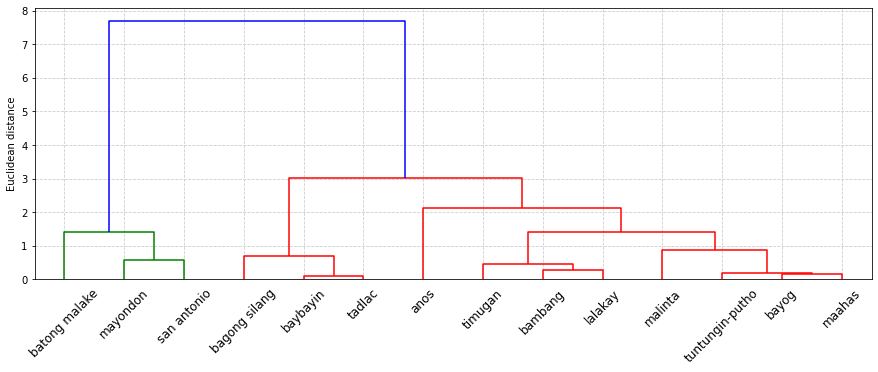

In [51]:
rcParams["figure.figsize"] = 15, 5
hac = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="ward")
new_df = yearly_df[["ongoing"	,"sus_prob_PCA"]]
plt.ylabel('Euclidean distance')
plt.grid(which="major",color="#ccc", linestyle="--")
dendro = sch.dendrogram(sch.linkage(new_df, method="ward", metric="euclidean"), labels=brngys, leaf_rotation=45)